# Homework 2 (Linear models, Optimization)

In this homework you will implement a simple linear classifier using numpy and your brain.

## Two-dimensional classification

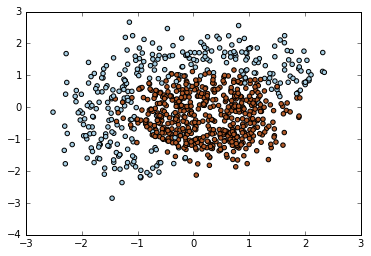

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [2]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [102]:
def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    expanded_x = expand(X)
    return np.sign(np.dot(expanded_x, w))


The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [103]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    expanded_x = expand(X)
    n_samples = X.shape[0]
    ones = np.ones((n_samples,))
    d = ones - y * np.dot(expanded_x, w)
    is_pos = (d > 0)
    return np.sum(d[is_pos]) / n_samples

    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    expanded_x = expand(X)
    n_samples = X.shape[0]
    ones = np.ones((n_samples,))
    d = ones - y * np.dot(expanded_x, w)
    is_pos = (d > 0)
    return np.sum(expanded_x * (-y[:, np.newaxis]) * is_pos[:, np.newaxis], axis=0) / n_samples


### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

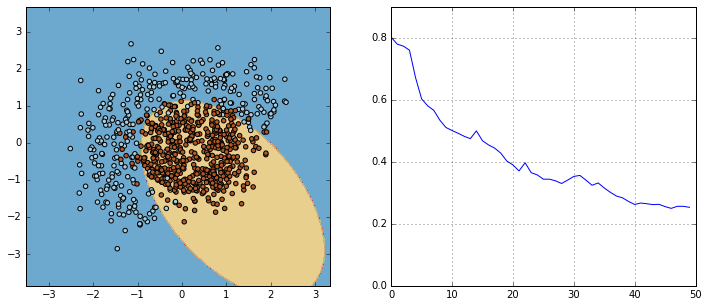

In [119]:
w = np.array([1, 0, 0, 0, 0, 0])

alpha = 0.1

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)
    
visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

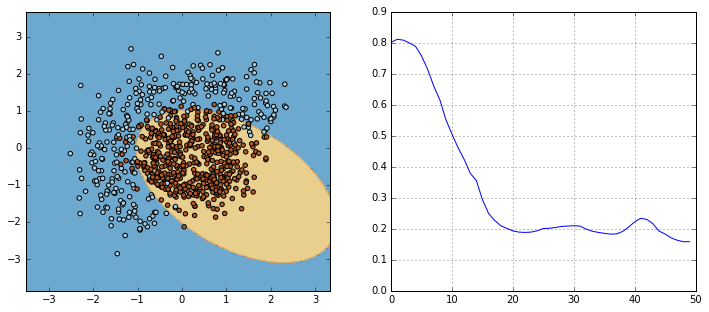

In [114]:
w = np.array([1, 0, 0, 0, 0, 0])

alpha = 0.1 # learning rate
mu    = 0.9 # momentum

v = np.array([0, 0, 0, 0, 0, 0])

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    grad = compute_grad(X[ind,:], y[ind], w)
    v = mu * v - alpha * grad
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

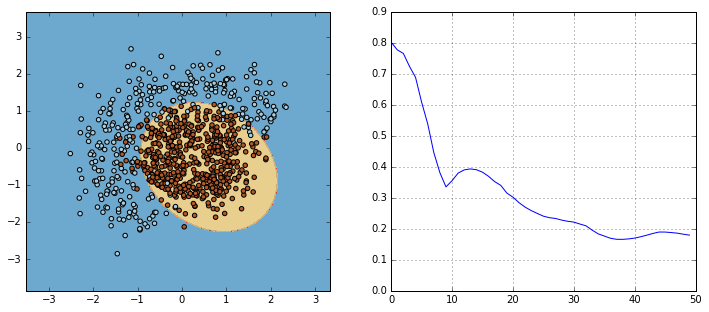

In [122]:
w = np.array([1, 0, 0, 0, 0, 0])

alpha = 0.1 # learning rate
mu    = 0.9 # momentum

v = np.array([0, 0, 0, 0, 0, 0])

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    grad = compute_grad(X[ind,:], y[ind], w + mu * v)
    v = mu * v - alpha * grad
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

Finally, try Adam algorithm. You can start with beta = 0.9 and mu = 0.999

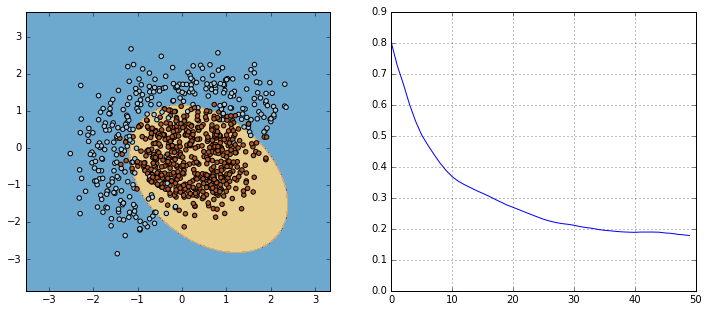

In [120]:
w = np.array([1, 0, 0, 0, 0, 0])

alpha = 0.1 # learning rate
beta = 0.9  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.999  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

v = np.array([0, 0, 0, 0, 0, 0])
g = np.array([0, 0, 0, 0, 0, 0])

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    grad = compute_grad(X[ind,:], y[ind], w)
    v = beta * v + (1 - beta) * grad
    v_ = v / (1 - beta ** (i + 1))
    g = mu * g + (1 - mu) * grad * grad
    g_ = g / (1 - mu ** (i + 1))
    w = w - alpha / np.sqrt(g_ + eps) * v_

visualize(X, y, w, loss, n_iter)
plt.clf()

Which optimization method do you consider the best? Type your answer in the cell below

Я считаю, что лучший оптимизатор - ADAM. Забудем, о том, что обычно ADAM лучше работает на практике и будем исходить из дз. Скорость сходимости у ADAM оказалась не хуже (на данном числе итераций и с одной и той же alpha), чем у остальных оптимизаторов + сходимость стабильная.